# Pre Processing

In [64]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
import torchaudio
from tqdm import tqdm
from audiomentations import Compose, AddBackgroundNoise, AddGaussianSNR

In [9]:
%pip install p

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Function to create a DataFrame
def create_file_dataframe(file_paths, emotion_levels, emotions):
    return pd.DataFrame({
        'File Name': file_paths,
        'Emotion Level': emotion_levels,
        'Emotion': emotions
    })


In [12]:
def display_distributions(dataframe, dataframe_name):
    sns.histplot(
        data = dataframe, 
        x = "Emotion Level"
    ).set(title = f"{dataframe_name} Emotion Level Distribution") #Emotion Level Distribution
    plt.show()
    sns.histplot(
        data = dataframe, 
        x = "Emotion"
    ).set(title = f"{dataframe_name} Emotion Distribution") #Emotion Distribution
    plt.show()

In [13]:
savee_base_path = "ALL"

In [14]:
savee_emotion_map = {
    "a": "Angry",
    "d": "Disgusted",
    "f": "Fearful",
    "h": "Happy",
    "n": "Neutral",
    "sa": "Sad",
    "su": "Surprised"
}

In [15]:
file_paths = []
emotions = []

# Looping through each file in the directory
for file_name in os.listdir(savee_base_path):
    # Extracting the last part after underscore (emotion identifier and file extension)
    file = file_name.split("_")[-1]
    
    # Extracting the emotion code by removing the file extension
    emotion = file.split(".")[0]  # Drops ".wav"
    emotion = emotion[0:2]        # First two characters
    
    # Handling cases where numeric is present in the code
    if emotion[-1].isnumeric():
        emotion = emotion[0]  # Gets only the first character if it is numeric (e.g., for Happy, Sad)

    # Storing the file path and corresponding emotion label
    file_paths.append(os.path.join(savee_base_path, file_name))
    emotions.append(savee_emotion_map.get(emotion, "Unknown"))  # Map to the emotion label

In [16]:
# Converting lists to numpy arrays
file_paths = np.array(file_paths)
emotions = np.array(emotions)

# Initializing emotion levels as zeros (adjust if necessary for your task)
emotion_levels = np.zeros(file_paths.shape)

# Verify the shapes of the arrays
print(file_paths.shape, emotion_levels.shape, emotions.shape)  # Expected output: (480,), (480,), (480,)

(480,) (480,) (480,)


In [17]:
# Creating the DataFrame
savee_file_dataframe = create_file_dataframe(file_paths, emotion_levels, emotions)

# Display the first few rows of the DataFrame
print(savee_file_dataframe.head(10))

        File Name  Emotion Level Emotion
0  ALL\DC_a01.wav            0.0   Angry
1  ALL\DC_a02.wav            0.0   Angry
2  ALL\DC_a03.wav            0.0   Angry
3  ALL\DC_a04.wav            0.0   Angry
4  ALL\DC_a05.wav            0.0   Angry
5  ALL\DC_a06.wav            0.0   Angry
6  ALL\DC_a07.wav            0.0   Angry
7  ALL\DC_a08.wav            0.0   Angry
8  ALL\DC_a09.wav            0.0   Angry
9  ALL\DC_a10.wav            0.0   Angry


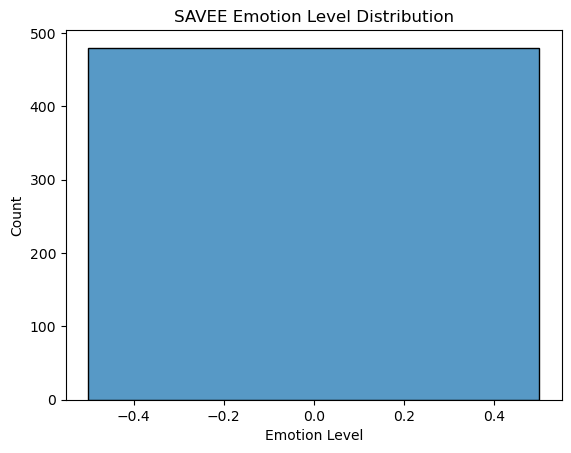

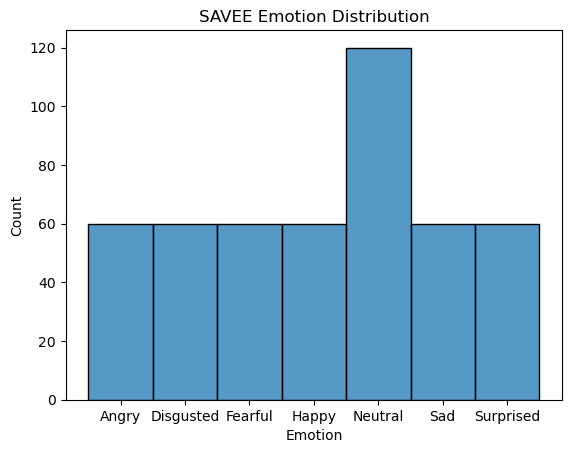

In [18]:
display_distributions(savee_file_dataframe, "SAVEE")

# Augmentation

In [19]:
# file_dataframes = [crema_d_files, ravdess_file_dataframe, tess_file_dataframe, savee_file_dataframe]
file_dataframes = [savee_file_dataframe]

In [20]:
combined_file_dataframe = pd.concat(file_dataframes, axis = 0)
combined_file_dataframe.head()

,File Name,Emotion Level,Emotion
0,ALL\DC_a01.wav,0.0,Angry
1,ALL\DC_a02.wav,0.0,Angry
2,ALL\DC_a03.wav,0.0,Angry
3,ALL\DC_a04.wav,0.0,Angry
4,ALL\DC_a05.wav,0.0,Angry


In [189]:
# display_distributions(combined_file_dataframe, "Combined Dataset")

In [ ]:
'''
combined_file_dataframe.replace({
    "Calm": "Neutral"
}, inplace = True)
combined_file_dataframe["Emotion"].unique()
'''

In [21]:
combined_file_dataframe["Emotion"].value_counts(normalize = True) * 100

Emotion
Neutral      25.0
Angry        12.5
Disgusted    12.5
Fearful      12.5
Happy        12.5
Sad          12.5
Surprised    12.5
Name: proportion, dtype: float64

In [22]:
combined_file_dataframe = combined_file_dataframe.drop("Emotion Level", axis = 1)
combined_file_dataframe.head()

,File Name,Emotion
0,ALL\DC_a01.wav,Angry
1,ALL\DC_a02.wav,Angry
2,ALL\DC_a03.wav,Angry
3,ALL\DC_a04.wav,Angry
4,ALL\DC_a05.wav,Angry


In [23]:
emotions = combined_file_dataframe["Emotion"].unique()
emotion_map = list(enumerate(emotions))
emotion_map_dict = {}
for emotion_mapping in emotion_map:
    emotion_map_dict[emotion_mapping[1]] = emotion_mapping[0]
emotion_map_dict

{'Angry': 0,
 'Disgusted': 1,
 'Fearful': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprised': 6}

In [24]:
combined_file_dataframe["Emotion"] = combined_file_dataframe["Emotion"].replace(emotion_map_dict)
combined_file_dataframe.head()

C:\Users\akshi\AppData\Local\Temp\ipykernel_8780\3380151486.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_file_dataframe["Emotion"] = combined_file_dataframe["Emotion"].replace(emotion_map_dict)


,File Name,Emotion
0,ALL\DC_a01.wav,0
1,ALL\DC_a02.wav,0
2,ALL\DC_a03.wav,0
3,ALL\DC_a04.wav,0
4,ALL\DC_a05.wav,0


In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [26]:
ohe = OneHotEncoder()
new_labels = ohe.fit_transform(combined_file_dataframe["Emotion"].to_numpy().reshape(-1, 1))
new_labels = new_labels.toarray()
new_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [27]:
emotion_files = combined_file_dataframe["File Name"].to_numpy()
labels = new_labels
emotion_files.shape, labels.shape

((480,), (480, 7))

In [28]:
test_ratio = 0.3
val_ratio = 0.2 #20% of 70% of dataset = 14% for validation
X, X_test, y, y_test = train_test_split(emotion_files, labels, test_size = test_ratio, random_state = 24)
X.shape, X_test.shape, y.shape, y_test.shape

((336,), (144,), (336, 7), (144, 7))

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = val_ratio, random_state = 24)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((268,), (68,), (268, 7), (68, 7))

In [30]:
#Preprocessing helper functions
#Standardizes waveform shape (desired shape = (66150, ))
def standardize_waveform_shape(waveform):
    audio_length = 66150
    if len(waveform) > audio_length:
        waveform = waveform[:audio_length]
    else:
        waveform = np.pad(waveform, (0, max(0, audio_length - len(waveform))), "constant")
    return waveform

In [31]:
#Takes .wav file, applies transformation, then returns spectogram
audio_path = "kitchen_2_Dishes_4_1_white_80.wav" 
def get_augmented_audio(audio_file):
    waveform, sample_rate = librosa.load(audio_file, duration = 3.0)
    
    waveform = standardize_waveform_shape(waveform)
    
    gaussian = AddGaussianSNR(
        min_snr_db = 3.0, 
        max_snr_db = 40
    )
    
    random_noise_path = audio_path
    background_noise = AddBackgroundNoise(
        sounds_path = random_noise_path,
        min_snr_db = 2.0,
        max_snr_db = 30.0
    )
    
    augmented_sound = gaussian(waveform, sample_rate = sample_rate)
    augment_sound = background_noise(waveform, sample_rate = sample_rate)
    
    mel_spectrogram = librosa.feature.melspectrogram(y = augmented_sound, sr = sample_rate)
    mel_spectrogram = mel_spectrogram.reshape(-1)
    
    return mel_spectrogram

In [32]:
def get_spectrogram(audio_file):
    waveshow, sample_rate = librosa.load(audio_file, duration = 3.0)
    waveshow = standardize_waveform_shape(waveshow)
    mel_spectrogram = librosa.feature.melspectrogram(y = waveshow, sr = sample_rate)
    mel_spectrogram = mel_spectrogram.reshape(-1)
    
    return mel_spectrogram

In [33]:
X_test_spectrograms = []
y_test_final = []

for audio_file, label in tqdm(zip(X_test, y_test)):
    spectrogram = get_spectrogram(audio_file)
    X_test_spectrograms.append(spectrogram)
    y_test_final.append(label)

144it [00:14,  9.65it/s]


In [34]:
X_test = np.array(X_test_spectrograms)
y_test = np.array(y_test_final)
X_test.shape, y_test.shape

((144, 16640), (144, 7))

In [35]:
X_train_spectrogram = []
y_train_final = []

percent_augmented_train = 0.4 #Augmenting 40% of train dataset

In [36]:
for audio_file, label in tqdm(zip(X_train, y_train)):
    random = np.random.default_rng().random()
    if random <= percent_augmented_train:
        spectrogram = get_augmented_audio(audio_file)
    else:
        spectrogram = get_spectrogram(audio_file)
    X_train_spectrogram.append(spectrogram)
    y_train_final.append(label)

0it [00:00, ?it/s]c:\Users\akshi\anaconda3\envs\pytorch\Lib\site-packages\audiomentations\core\audio_loading_utils.py:37: UserWarning: c:\Users\akshi\Downloads\EmDet\EmDet\kitchen_2_Dishes_4_1_white_80.wav had to be resampled from 16000 Hz to 22050 Hz. This hurt execution time.
  warnings.warn(
268it [00:04, 54.42it/s]


In [37]:
X_train = np.array(X_train_spectrogram)
y_train = np.array(y_train_final)
X_train.shape, y_train.shape

((268, 16640), (268, 7))

In [38]:
X_val_spectrogram = []
y_val_final = []

percent_augmented_val = 0.4 #Augmenting 40% of validation dataset

In [39]:
for audio_file, label in tqdm(zip(X_val, y_val)):
    random = np.random.default_rng().random()
    if random <= percent_augmented_val:
        spectrogram = get_augmented_audio(audio_file)
    else:
        spectrogram = get_spectrogram(audio_file)
    X_val_spectrogram.append(spectrogram)
    y_val_final.append(label)

68it [00:01, 51.49it/s]


In [40]:
X_val = np.array(X_val_spectrogram)
y_val = np.array(y_val_final)
X_val.shape, y_val.shape

((68, 16640), (68, 7))

# Model Training

In [42]:
%pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached wrapt-1.16.0-cp311-cp311-win_amd64.whl.metadata (6.8 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 1.2 MB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.4/385.0 MB 8.1 MB/s eta 0:00:48
   -------------------------

In [43]:
import tensorflow as tf

In [44]:
n_features = X_train.shape[-1]
n_outputs = y_train.shape[-1]
n_features, n_outputs

(16640, 7)

In [45]:
model_simple = tf.keras.Sequential([
    tf.keras.layers.Conv1D(256, 5, activation = "relu", input_shape = (n_features, 1)),
    tf.keras.layers.MaxPool1D(pool_size = 5, strides = 2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv1D(256, 5, activation = "relu"),
    tf.keras.layers.MaxPool1D(pool_size = 5, strides = 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv1D(128, 5, activation = "relu", input_shape = (n_features, 1)),
    tf.keras.layers.MaxPool1D(pool_size = 5, strides = 2, padding = "same"),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv1D(128, 5, activation = "relu", input_shape = (n_features, 1)),
    tf.keras.layers.MaxPool1D(pool_size = 5, strides = 2, padding = "same"),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv1D(64, 5, activation = "relu", input_shape = (n_features, 1)),
    tf.keras.layers.MaxPool1D(pool_size = 5, strides = 2, padding = "same"),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv1D(64, 5, activation = "relu", input_shape = (n_features, 1)),
    tf.keras.layers.MaxPool1D(pool_size = 5, strides = 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv1D(32, 5, activation = "relu", input_shape = (n_features, 1)),
    tf.keras.layers.MaxPool1D(pool_size = 5, strides = 2),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n_outputs, activation = "softmax") #output layer
])

c:\Users\akshi\anaconda3\envs\pytorch\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
model_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 16636, 256)     │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8316, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8316, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8312, 256)      │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4154, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4154, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4150, 128)      │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2075, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2075, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2071, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1036, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1036, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1032, 64)       │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 516, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 516, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 512, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 254, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 254, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 250, 32)        │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 123, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 123, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        27,559 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 674,887 (2.57 MB)

 Trainable params: 674,887 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model_simple.compile(
    optimizer = "adam",
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [48]:
model_attempt = 1

In [53]:
val_callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    min_delta = 0.1,
    patience = 6,
    verbose = 1,
    restore_best_weights = True
)
checkpoint_path = "C:/Users/akshi/Downloads/EmDet/EmDet/working/ACCURACY{val_accuracy}.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = "val_accuracy",
    verbose = 1,
    save_freq = "epoch"
)

In [54]:
history = model_simple.fit(
    X_train, y_train,
    epochs = 50,
    callbacks = [checkpoint],
    validation_data = (X_val, y_val)
)
model_attempt += 1

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2052 - loss: 2.4107
Epoch 1: saving model to C:/Users/akshi/Downloads/EmDet/EmDet/working/ACCURACY0.3382352888584137.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 9s/step - accuracy: 0.2063 - loss: 2.4011 - val_accuracy: 0.3382 - val_loss: 1.9028
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.2714 - loss: 2.0181 
Epoch 2: saving model to C:/Users/akshi/Downloads/EmDet/EmDet/working/ACCURACY0.29411765933036804.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 116s 13s/step - accuracy: 0.2719 - loss: 2.0188 - val_accuracy: 0.2941 - val_loss: 1.8711
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3651 - loss: 1.8249 
Epoch 3: saving model to C:/Users/akshi/Downloads/EmDet/EmDet/working/ACCURACY0.23529411852359772.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 119s 11s/step - accuracy: 0.3644 - loss: 1.8235 - val_accuracy: 0.2353 - val_loss: 1.9005
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3473 - loss: 1.7498 
Epoch 4: saving 

In [74]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the saved .keras model
model = load_model('"C:/Users/akshi/Downloads/ACCURACY0.37472161650657654.keras"')

# Compile the model if needed (uncomment if you need to change optimizer/loss)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define ModelCheckpoint to save the model during training
checkpoint = ModelCheckpoint(
    'C:/Users/akshi/Downloads/EmDet/EmDet/working/BestModel.keras',  # Change path as needed
    monitor='val_accuracy',  # Or any other metric you want to monitor
    save_best_only=True,
    mode='max'
)

# Continue training
history = model.fit(
    X_train, y_train,
    epochs=10,  # Total epochs to train
    callbacks=[checkpoint],
    validation_data=(X_val, y_val),
    initial_epoch=1  # Add this if you want to specify where to continue from
)

# Save the updated model if desired
#model.save('C:/Users/akshi/Downloads/EmDet/EmDet/working/Updated1Model.keras')


Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 9s/step - accuracy: 0.7557 - loss: 0.6911 - val_accuracy: 0.4265 - val_loss: 3.8371
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 9s/step - accuracy: 0.7805 - loss: 0.5829 - val_accuracy: 0.4706 - val_loss: 3.1673
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 9s/step - accuracy: 0.8143 - loss: 0.5044 - val_accuracy: 0.5000 - val_loss: 3.4306
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.8162 - loss: 0.4993 - val_accuracy: 0.4559 - val_loss: 3.5543
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 9s/step - accuracy: 0.7935 - loss: 0.4814 - val_accuracy: 0.5147 - val_loss: 3.7887
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 9s/step - accuracy: 0.8311 - loss: 0.4329 - val_accuracy: 0.4853 - val_loss: 4.3552
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 9s/step - accuracy: 0.8466 - loss: 0.3749 - val_accuracy: 0.4706 - val_loss: 4.7286
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 9s/step - accuracy: 0.7930 - loss: 0.6198 - val_accuracy: 0.4412 - val_loss: 5.9498
Epoch 10

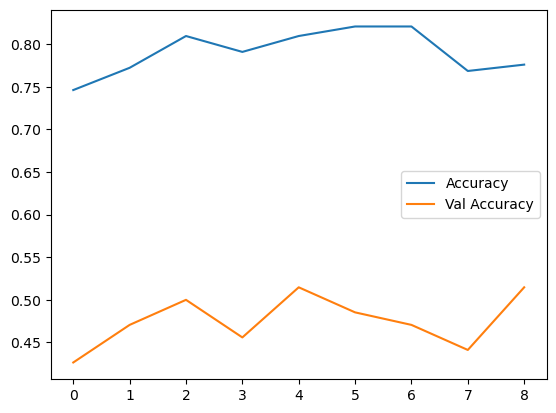

In [75]:

plt.plot(history.history["accuracy"], label = "Accuracy")
plt.plot(history.history["val_accuracy"], label = "Val Accuracy")
plt.legend()

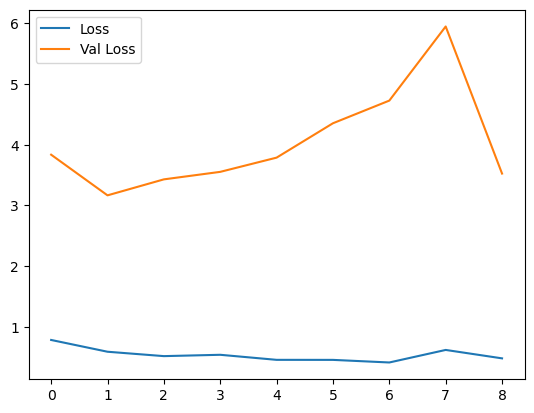

In [76]:
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.legend()

Num GPUs Available:  0
